# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

We need to:
- Rewrite the whole code in the form of a unique function that creates the samples, performes the rolling regression and Kalman estimations, and returns all the performance metrics.
- Then we should run this function a lot of times to gather statistics on the performance.
- We should think carefully about what kind of statistical test we can make to decide whether the performance of one method is significantly superior.
- We could add more factor shapes.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [1055]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter

In [1056]:
# Helper functions
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
performance_record_mse = {}
performance_record_wacc = {}

def plot_estimated_sensitivities(sens, est_sens, colors):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    axc = ax[0,0]
    axc.plot(est_sens.iloc[:,0], c=colors[0])
    axc.plot(sens.iloc[:,0], '--', c='k')
    axc = ax[0,1]
    axc.plot(est_sens.iloc[:,1], c=colors[1])
    axc.plot(sens.iloc[:,1], '--', c='k')
    axc = ax[1,0]
    axc.plot(est_sens.iloc[:,2], c=colors[2])
    axc.plot(sens.iloc[:,2], '--', c='k')
    
def compute_estimated_returns(factors, est_sens):
    return pd.Series(np.multiply(factors, est_sens).sum(axis=1))

def plot_residuals(estimated_returns, returns):
    residuals = estimated_returns - returns
    plt.scatter(residuals.index, residuals, s=0.5)
    
def print_mse_performance(estimated_returns, returns, name):
    square_errors = np.square(estimated_returns - returns)
    mean_square_error = square_errors.sum()/len(estimated_returns)
    performance_record_mse[name] = mean_square_error
    print(f"MSE for {name}, assuming the factors known: {mean_square_error}")
    
def print_weighted_accuracy_performance(estimated_returns, returns, name):
    weights = abs(returns)
    correct_sign = -2*np.logical_xor(estimated_returns > 0, returns > 0) + 1
    weighted_accuracy = np.multiply(weights, correct_sign).mean()
    performance_record_wacc[name] = weighted_accuracy
    print(f"Weighted accuracy for {name}, assuming the factors known: {weighted_accuracy}")
    
def plot_prediction_performance(factors, returns, est_sens, name):
    estimated_returns = compute_estimated_returns(factors, est_sens)
    print_mse_performance(estimated_returns, returns, name)
    print_weighted_accuracy_performance(estimated_returns, returns, name)
    plot_residuals(estimated_returns, returns)
    

In [1057]:
# Sensitivities
timespan = 10000
pi = 3.1415
t = np.linspace(0,timespan-1,timespan,dtype=np.float64)
sens1 = -(pd.Series(np.arctan((t-timespan/2)/timespan*100)) - pi/2)/pi
sens2 = (pd.Series(np.sin(t/timespan*3.2 - 1.5)) + 1)/2
sens3 = pd.Series(np.sin(t/timespan*5) + np.sin(t/timespan*10 + 150) + \
                  np.sin(t/timespan*20 + 150))/2
sens = pd.concat([sens1, sens2, sens3], axis=1)

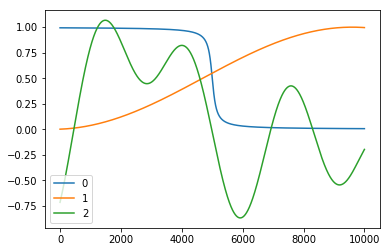

In [1058]:
sens.plot()

In [1059]:
# Factors
factor1 = pd.Series(np.random.normal(size=timespan))
factor2 = pd.Series(np.random.normal(size=timespan))
factor3 = pd.Series(np.random.normal(size=timespan))
factors = pd.concat([factor1, factor2, factor3], axis=1)

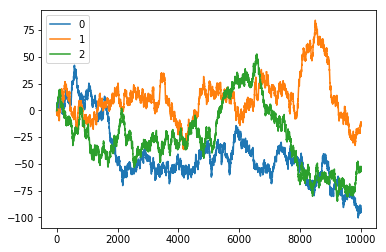

In [1060]:
factors.cumsum(axis=0).plot()

In [1061]:
# Returns
error = np.random.normal(size=timespan)*1.0
returns = pd.Series(np.multiply(factors, sens).sum(axis=1) + error)

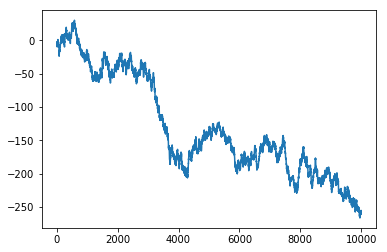

In [1062]:
returns.cumsum().plot()

## Constant regression

In [1063]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(factors, returns)
est_sens = reg.coef_
est_sens

array([0.49218081, 0.54592021, 0.1644213 ])

MSE for Constant OLS, assuming the factors known: 1.6663213115527138
Weighted accuracy for Constant OLS, assuming the factors known: 0.5931275783082479


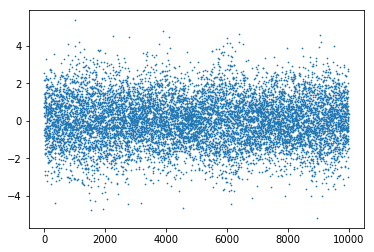

In [1064]:
plot_prediction_performance(factors, returns, est_sens, "Constant OLS")

## Rolling regression

In [1065]:
window = 200
model = PandasRollingOLS(y=returns, x=factors, window=window)
est_sens_rolreg = pd.DataFrame(model.beta)

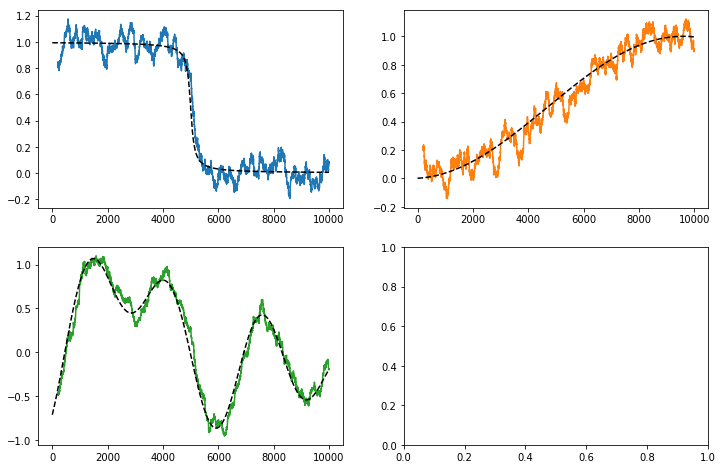

In [1066]:
plot_estimated_sensitivities(sens, est_sens_rolreg, colors)

MSE for Rolling regression, assuming the factors known: 0.9955883041984157
Weighted accuracy for Rolling regression, assuming the factors known: 0.8823272695272238


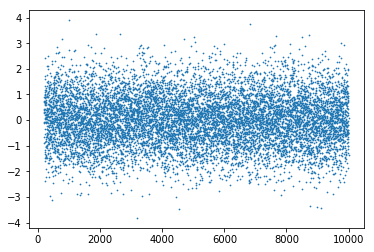

In [1067]:
plot_prediction_performance(factors.iloc[window-1:,:], returns.iloc[window-1:], est_sens_rolreg, "Rolling regression")

## Weighted rolling regression

In [1068]:
# How to do that efficiently??

## Kalman filter

In [1069]:
n_dim_state=3
n_dim_obs=1
observation_covariance = 1
transition_covariance = np.eye(3)*0.0001
observation_matrices = factors.values[:,np.newaxis,:]
kf = KalmanFilter(initial_state_mean=[0,0,0], 
                  n_dim_state=n_dim_state, 
                  n_dim_obs=n_dim_obs, 
                  observation_matrices=observation_matrices,
                  observation_covariance=observation_covariance,
                  transition_covariance=transition_covariance
                 )

In [1070]:
filtered_state_means, filtered_state_covariances = kf.filter(returns)
filtered_state_means = pd.DataFrame(filtered_state_means)

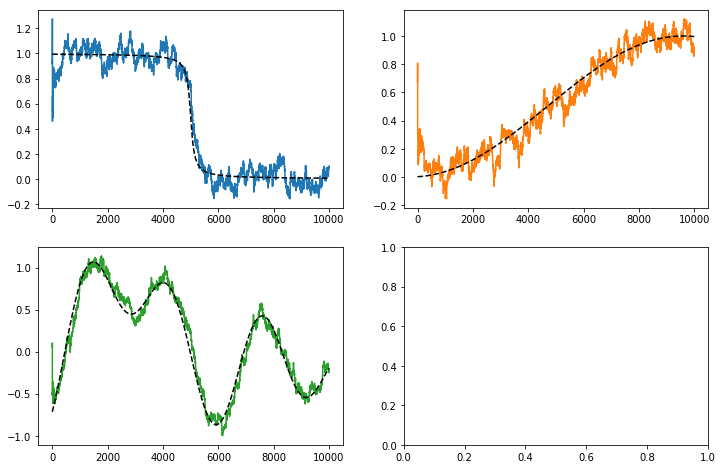

In [1071]:
plot_estimated_sensitivities(sens, filtered_state_means, colors)

MSE for Kalman, assuming the factors known: 0.965379015757686
Weighted accuracy for Kalman, assuming the factors known: 0.8862436868627418


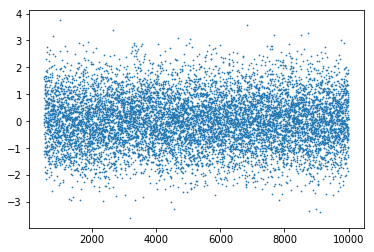

In [1072]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], filtered_state_means.iloc[burn_period:,:], "Kalman")

In [1073]:
# Naive trend correction...
trend_factor = .5
rolling_mean = pd.DataFrame(filtered_state_means).rolling(100, axis=0).mean()
trend_est_sens = (1 + trend_factor)*pd.DataFrame(filtered_state_means) - trend_factor*rolling_mean

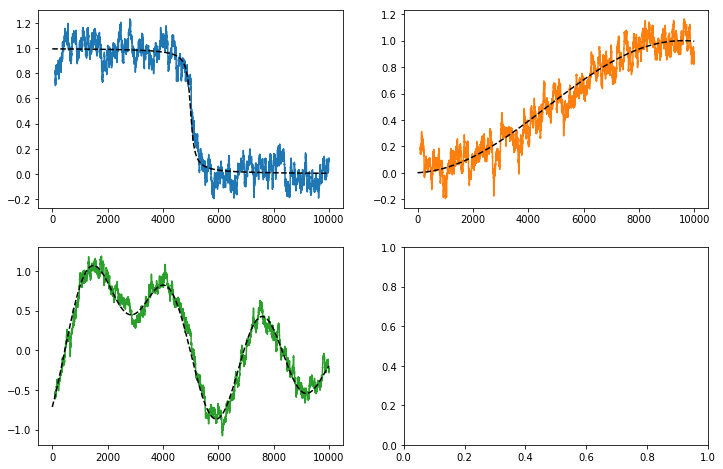

In [1074]:
plot_estimated_sensitivities(sens, trend_est_sens, colors)

MSE for Kalman naive trend, assuming the factors known: 0.9404688097190923
Weighted accuracy for Kalman naive trend, assuming the factors known: 0.892236765156838


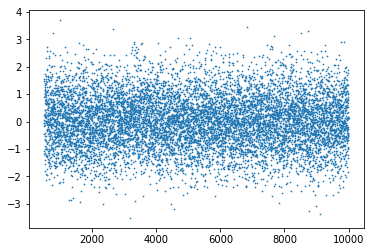

In [1075]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], trend_est_sens.iloc[burn_period:,:], "Kalman naive trend")

## Bentz's random trend Kalman filter

In [1076]:
n_dim_state=6
n_dim_obs=1
observation_covariance = 1
transition_covariance = 1e-9*np.eye(6)#np.kron(np.eye(3),np.array([[1,0],[0,1]]))#
observation_matrices = np.array([factors.values[:, 0], 0*factors.values[:, 0],
                                 factors.values[:, 1], 0*factors.values[:, 1],
                                 factors.values[:, 2], 0*factors.values[:, 2]]).transpose()[:, np.newaxis,:]
transition_matrix = np.kron(np.eye(3), np.array([[1, 1], [0, 1]]))
kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0, 0, 0], 
                  n_dim_state=n_dim_state, 
                  n_dim_obs=n_dim_obs, 
                  observation_matrices=observation_matrices,
                  observation_covariance=observation_covariance,
                  transition_covariance=transition_covariance,
                  transition_matrices=transition_matrix
                 )

In [1077]:
filtered_state_means, filtered_state_covariances = kf.filter(returns)
print(filtered_state_means)
filtered_state_means = pd.DataFrame(filtered_state_means[:,[0,2,4]])

[[ 9.35951492e-01  0.00000000e+00  6.71380833e-01  0.00000000e+00
   5.53765833e-02  0.00000000e+00]
 [ 9.21398241e-01 -2.80985084e-03  7.29722522e-01  3.23749708e-02
   6.56324074e-02  5.39219363e-03]
 [ 1.29726894e+00  1.62205627e-01  8.63250264e-01  9.66767984e-02
   1.47116971e-01  3.89135558e-02]
 ...
 [ 1.24156912e-01  4.28150897e-04  9.01870943e-01 -3.67670703e-04
  -1.38442075e-01  4.54267480e-04]
 [ 1.19823966e-01  4.11602696e-04  8.89725931e-01 -4.13652425e-04
  -1.45827318e-01  4.21583840e-04]
 [ 1.19472098e-01  4.08716527e-04  8.89212293e-01 -4.13994761e-04
  -1.45303742e-01  4.22080471e-04]]


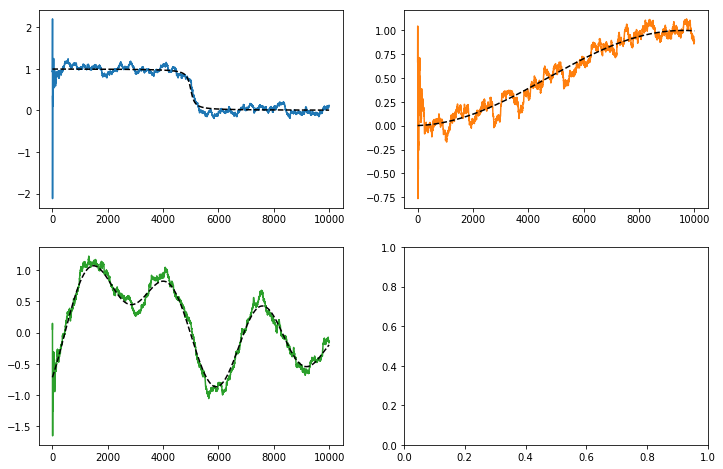

In [1078]:
plot_estimated_sensitivities(sens, filtered_state_means, colors)

MSE for Kalman Bentz trend, assuming the factors known: 0.9759733554556264
Weighted accuracy for Kalman Bentz trend, assuming the factors known: 0.8855815023199701


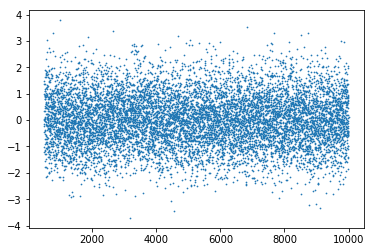

In [1079]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], filtered_state_means.iloc[burn_period:,:], "Kalman Bentz trend")

## Performance summary

In [1081]:
pd.Series(performance_record_mse)

Constant OLS          1.666321
Rolling regression    0.995588
Kalman                0.965379
Kalman naive trend    0.940469
Kalman Bentz trend    0.975973
dtype: float64

In [1082]:
pd.Series(performance_record_wacc)

Constant OLS          0.593128
Rolling regression    0.882327
Kalman                0.886244
Kalman naive trend    0.892237
Kalman Bentz trend    0.885582
dtype: float64

## Own implementation of the Kalman filter

In [1080]:
# TO ADAPT!!!

# Define the required variables on the first run of the Kalman filter
if self.est_st is None:
    # The estimated state
    self.est_st = np.transpose(np.atleast_2d(np.zeros([1,len(self.securities)])))
    # The estimated covariance of the state estimate
    self.est_st_cov = np.zeros([len(self.securities),len(self.securities)])

# The mean has to be estimated before running the Kalman filter
self.mean = -self.est_st[len(self.securities)-1]

# The covariance of the state transition model (following Chan's choice).
trans_cov = delta/(1 - delta) * np.identity(len(self.securities))
# The covariance of the observation model
obs_cov = gamma

# Prediction
# The prediction for the state is the current estimated value
pred_st = self.est_st
# The prediction of the covariance is
pred_st_cov = self.est_st_cov + trans_cov

# Observation
obs = context.price_data.iloc[-1,0]
# Observation model
obs_mod = context.price_data.iloc[-1,1:len(self.securities)]
obs_mod['constant'] = 1
obs_mod = np.atleast_2d(obs_mod)
# Measurement residual
obs_res = obs - np.dot(obs_mod, pred_st)
# Residual covariance
res_cov = np.dot( np.dot( obs_mod, pred_st_cov ), np.transpose(obs_mod) ) + obs_cov
# Kalman optimal gain
kal_gain = np.dot( np.dot( pred_st_cov, np.transpose(obs_mod) ), np.linalg.inv(np.atleast_2d(res_cov)) )

# Update
# Updated state estimate
self.est_st = pred_st + obs_res*kal_gain
# Updated convariance estimate
fact = np.identity(len(self.securities)) - np.dot(kal_gain, obs_mod)
self.est_st_cov = np.dot(fact, pred_st_cov)

# Extracting the weights
hedge_ratios = self.est_st[0:len(self.securities)-1]
weights = [np.insert(hedge_ratios, 0, -1)]
# Normalizes the weights
abs_sum_weights = np.nansum(np.absolute(weights))
weights = weights/abs_sum_weights
# Stores the weights
self.weights = pd.DataFrame(weights, index = [0], columns = self.securities)
# Normalizes the mean
self.mean = self.mean/abs_sum_weights
# The volatility
self.vol = np.sqrt(res_cov)/abs_sum_weights
# The z-score
self.z_score = -obs_res/self.vol

NameError: name 'self' is not defined